# Processing the Ghana sub-reflector (SR) photogrammetry targets data

In [1]:
import pandas
import pylab
import numpy as np
import itertools
import math
import matplotlib
import scipy.optimize as opt
import matplotlib.pyplot as mpl
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
%matplotlib inline

In [2]:
def rotate(origin, point, angle):
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

## i) Read in the SR shaped profile (approximation from LAR)

In [3]:
#2D profile from Lyrebird Antenna Research (LAR)
SR_LAR_profile = pandas.read_csv('SR_LAR_TIW_32m_GRASP_2.rsf',delimiter="\s+",header=None)
SR_LAR_rad = SR_LAR_profile[0] #radius in meters
SR_LAR_z_2D = SR_LAR_profile[1] #height(z-axis) in meters
SR_LAR_z_2D = SR_LAR_z_2D - SR_LAR_z_2D[0] #subtract offset

## ii) Read in the photogrammetry data 

In [4]:
filenme = 'ghana_sr_28May_final.csv'
data = pandas.read_csv(filenme,delimiter=";",header=None) #read in the raw photogrammetry data

In [5]:
data.head()

,0,1,2,3,4,5,6
0,1,,-2.269423,6.121835,7.215883,0.490790,0.840631
1,2,,-2.725282,6.222918,7.035366,0.530843,1.472989
2,3,,-3.091535,5.958527,7.201189,0.427580,0.880933
3,4,,-3.349019,6.342195,7.037791,0.267134,0.469777
4,5,,-3.791735,6.417176,7.206555,0.745088,1.486022


In [6]:
# Grab specific data not part of fitting
ar1 = data.loc[data[1] == 'ar1'] #grab strips ar1
ar2 = data.loc[data[1] == 'ar2'] #grab strips ar2
ar3 = data.loc[data[1] == 'ar3'] #grab strips ar3
ar4 = data.loc[data[1] == 'ar4'] #grab strips ar4
ruler_1 = np.array(data.loc[data[0] == 49]) #grab ruler point 1
ruler_2 = np.array(data.loc[data[0] == 50]) #grab ruler point 2
orig_x1 = np.array(data.loc[data[1] == 'x1']) #grab origin point x1
orig_x2 = np.array(data.loc[data[1] == 'x2']) #grab origin point x2
orig_y1 = np.array(data.loc[data[1] == 'y1']) #grab origin point y1
orig_y2 = np.array(data.loc[data[1] == 'y2']) #grab origin point y2
ar1_L = np.array(data.loc[data[1] == 'ar1_L']) #grab farout point
ar1_R = np.array(data.loc[data[1] == 'ar1_R']) #grab farout point
ar2_L = np.array(data.loc[data[1] == 'ar2_L']) #grab farout point
ar2_R = np.array(data.loc[data[1] == 'ar2_R']) #grab farout point
ar3_L = np.array(data.loc[data[1] == 'ar3_L']) #grab farout point
ar3_R = np.array(data.loc[data[1] == 'ar3_R']) #grab farout point
ar4_L = np.array(data.loc[data[1] == 'ar4_L']) #grab farout point
ar4_R = np.array(data.loc[data[1] == 'ar4_R']) #grab farout point

In [7]:
# Rewrite data for fitting purpose / remove other points
data = data.loc[data[1] != 'ar1'] #remove strips ar1
data = data.loc[data[1] != 'ar2'] #remove strips ar2
data = data.loc[data[1] != 'ar3'] #remove strips ar3
data = data.loc[data[1] != 'ar4'] #remove strips ar4
data = data.loc[data[0] != 49] #remove ruler point 1
data = data.loc[data[0] != 50] #remove ruler point 2
data = data.loc[data[1] != 'pt1'] #remove direction reference point 1
data = data.loc[data[1] != 'pt2'] #remove direction reference point 2

In [8]:
# Read in mockup perfect data for outer rim for contour plot
data_OR = pandas.read_csv('ghana_SR_outerRim.csv',delimiter=",",header=None)
x_OR = data_OR[0]
y_OR = data_OR[1]
z_OR = data_OR[2]

## iii) Remove the gross offsets from x, y, and z coordinates & plot data

In [9]:
# Extract ID, x, y and z points from the csv file
ID = data[0]
name = data[1]
doex = data[2]
doey = data[3]
doez = data[4]

# Extract RMS and max residual Photomodeler data
res_RMS = data[5]
res_max = data[6]

# Find x and y center

x_center = orig_x1[0,2] + (orig_x2[0,2] - orig_x1[0,2])/2
y_center = orig_y1[0,3] + (orig_y2[0,3] - orig_y1[0,3])/2

# Align all points around x,y center and remove the z offset
doex = doex - x_center
doey = doey - y_center
doez = doez - min(doez)
ruler_x1 = ruler_1[0,2] - x_center
ruler_y1 = ruler_1[0,3] - y_center
ruler_z1 = ruler_1[0,4] - min(doez)
ruler_x2 = ruler_2[0,2] - x_center
ruler_y2 = ruler_2[0,3] - y_center
ruler_z2 = ruler_2[0,4] - min(doez)

orig_x1_x = orig_x1[0,2] - x_center
orig_x1_y = orig_x1[0,3] - y_center
orig_x1_z = orig_x1[0,4] - min(doez)
orig_x2_x = orig_x2[0,2] - x_center
orig_x2_y = orig_x2[0,3] - y_center
orig_x2_z = orig_x2[0,4] - min(doez)
orig_y1_x = orig_y1[0,2] - x_center
orig_y1_y = orig_y1[0,3] - y_center
orig_y1_z = orig_y1[0,4] - min(doez)
orig_y2_x = orig_y2[0,2] - x_center
orig_y2_y = orig_y2[0,3] - y_center
orig_y2_z = orig_y2[0,4] - min(doez)

# Add outer rim points to initial targets from Photomodeler to use in contour plot
doex_wide = pandas.concat([doex, x_OR])
doey_wide = pandas.concat([doey, y_OR])
doez_wide = pandas.concat([doez, z_OR-0.065])

r = np.sqrt(doex**2 + doey**2)

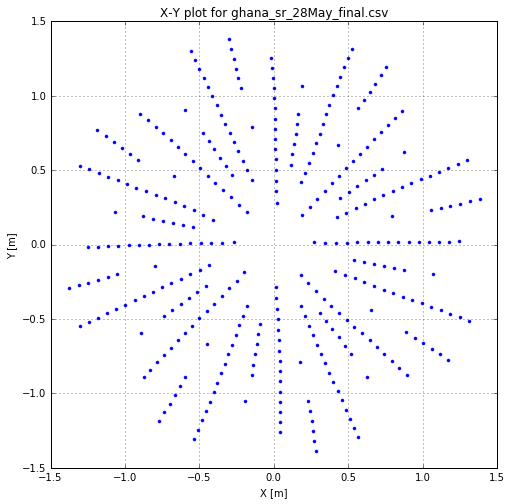

In [10]:
# Plot x,y plane
fig = plt.figure(figsize=(8,8))
pylab.plot(doex,doey,'.')
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.title("X-Y plot for " + filenme)
plt.grid()

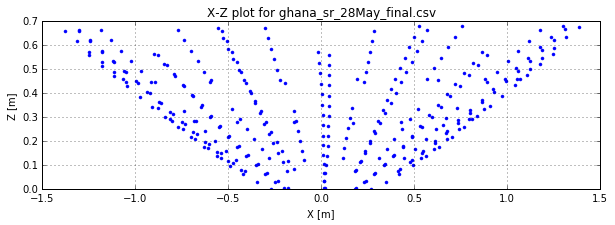

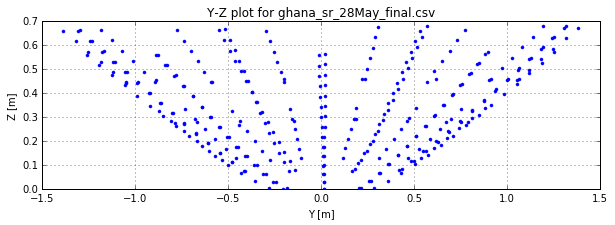

In [11]:
# Plot x,z plane
fig = plt.figure(figsize=(10,3))
pylab.plot(doex,doez,'.')
plt.xlabel("X [m]")
plt.ylabel("Z [m]")
plt.title("X-Z plot for " + filenme)
plt.grid()
# Plot y,z planY
fig = plt.figure(figsize=(10,3))
pylab.plot(doey,doez,'.')
plt.xlabel("Y [m]")
plt.ylabel("Z [m]")
plt.title("Y-Z plot for " + filenme)
plt.grid()

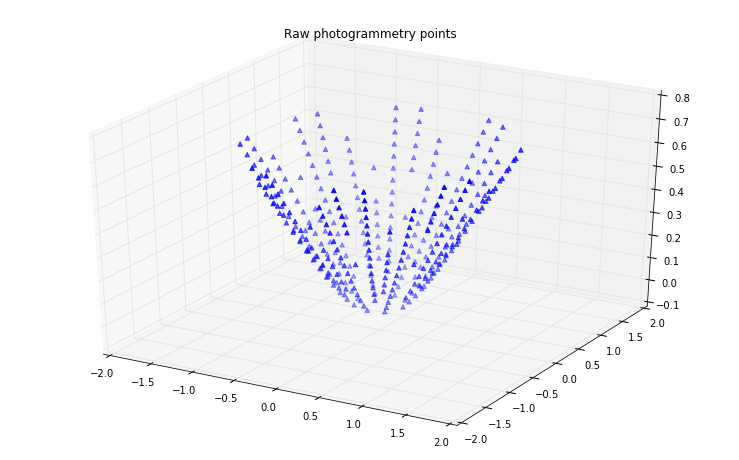

In [12]:
fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot(111, projection='3d')
#plot the raw data
ax.scatter(doex,doey,doez,marker='^',label='Raw',color='b')
plt.title('Raw photogrammetry points')

## 1) Compare to LAR profile

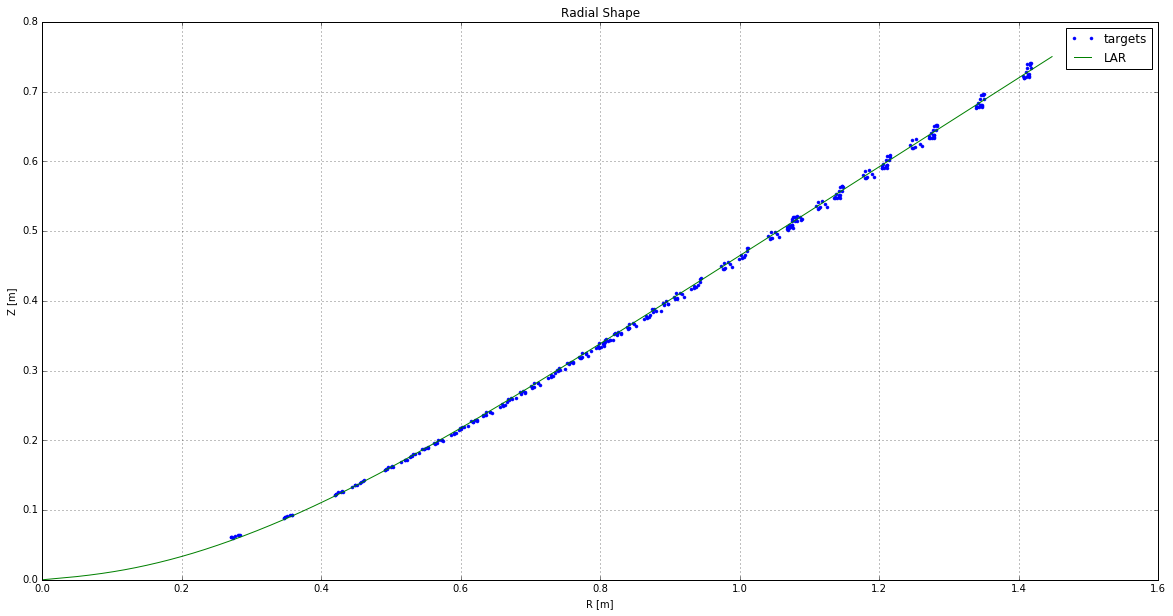

In [13]:
fig = plt.figure(figsize=(20,10))
pylab.plot(r,doez+0.06,'.',label='targets')
pylab.plot(SR_LAR_rad,SR_LAR_z_2D,'-',label='LAR')
pylab.xlabel('R [m]')
pylab.ylabel('Z [m]')
pylab.title('Radial Shape')
axes = plt.gca()
#axes.set_xlim([1.41,1.44])
#axes.set_ylim([0.72,0.75])
pylab.legend()
plt.grid()

## 2) Polynomial fitting

### 2.1) Fit polynomial to 2D radial curve

In [14]:
r = np.sqrt(doex**2 + doey**2)
poly = np.polyfit(r, doez, 7)
poly

array([ 0.28325454, -1.69486013,  4.18688377, -5.39347298,  3.62467232,
       -0.88705537,  0.36534399, -0.08182718])

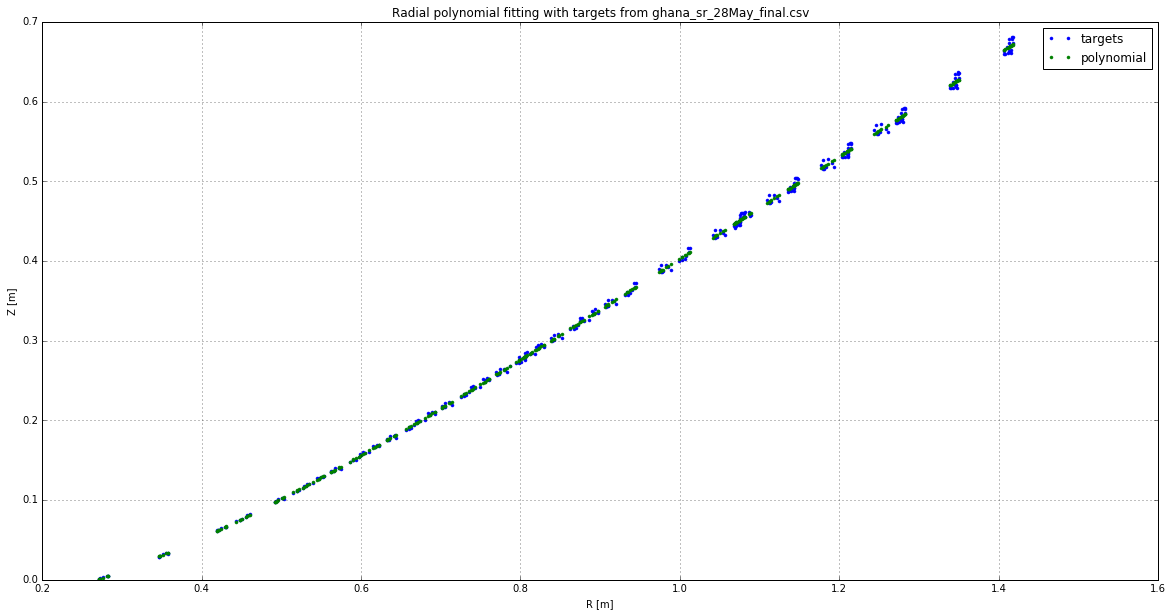

In [15]:
fig = plt.figure(figsize=(20,10))
pylab.plot(r,doez,'.',label='targets')
pylab.plot(r,np.polyval(poly, r),'.',label='polynomial')
pylab.xlabel('R [m]')
pylab.ylabel('Z [m]')
pylab.title('Radial polynomial fitting with targets from ' + filenme)
axes = plt.gca()
#axes.set_xlim([1.12,1.13])
#axes.set_ylim([0.475,0.485])
pylab.legend()
plt.grid()

### 2.2) Plot the radial errors from the 2D poly fitting

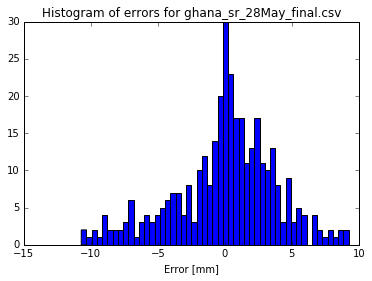

In [16]:
plt.hist(1000*(np.polyval(poly, r)-doez),51)
plt.xlabel('Error [mm]')
plt.title('Histogram of errors for ' + filenme)

### 2.3) Apply cubic interpolation to poly errors

In [17]:
poly_z = np.polyval(poly, r)
index = np.linspace(0, np.size(poly_z)-1, num=np.size(poly_z))
poly_z = pandas.DataFrame(poly_z, index=index)

In [18]:
#rotate to coincide with holography maps
rotate_ang = -137;
ruler_x1_rot, ruler_y1_rot = rotate([0,0], [ruler_x1,ruler_y1], math.radians(rotate_ang))
ruler_x2_rot, ruler_y2_rot = rotate([0,0], [ruler_x2,ruler_y2], math.radians(rotate_ang))
doex_wide, doey_wide = rotate([0,0], [doex_wide,doey_wide], math.radians(rotate_ang))
doex, doey = rotate([0,0], [doex,doey], math.radians(rotate_ang))

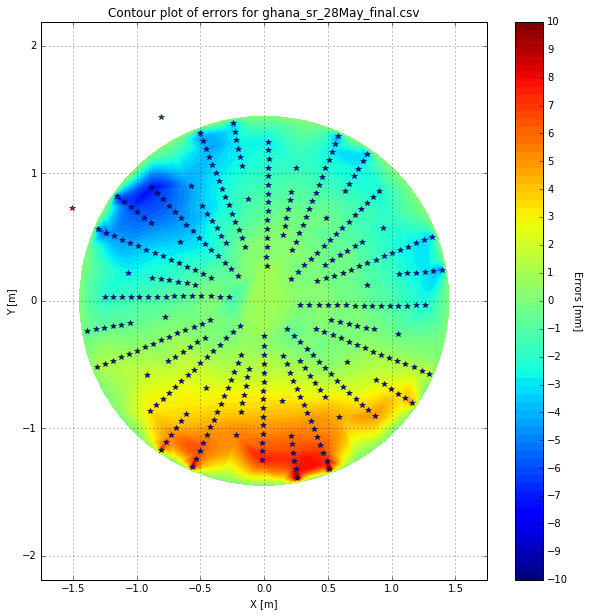

In [19]:
N = 1000
meth = 'cubic'
xi = np.linspace(doex_wide.min(), doex_wide.max(), N)
yi = np.linspace(doey_wide.min(), doey_wide.max(), N)

doez_wide = pandas.concat([doez, z_OR])
zi_targets = interpolate.griddata((doex_wide, doey_wide), doez_wide, (xi[None,:], yi[:,None]), method=meth)
poly_z_wide = pandas.concat([poly_z[0], z_OR])
zi_poly = interpolate.griddata((doex_wide, doey_wide), poly_z_wide, (xi[None,:], yi[:,None]), method=meth)
z_diff_poly = (zi_targets-zi_poly)*1000*0.755 #error in millimeter; 0.755 calculated as normal angle factor
fig = plt.figure(figsize=(10,10))
plt.axis('equal')
plt.grid()
v = np.linspace(-10, 10, 70, endpoint=True)
contours = plt.contourf(xi, yi, z_diff_poly, v, cmap=plt.cm.jet)
pylab.plot(doex,doey,'*')
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
pylab.title('Contour plot of errors for ' + filenme)
pylab.plot(ruler_x1_rot,ruler_y1_rot,'*',ruler_x2_rot,ruler_y2_rot,'*')
axes = plt.gca()
axes.set_xlim([-1.75,1.75])
axes.set_ylim([-1.5,1.5])
v2 = np.linspace(-10, 10, 21, endpoint=True)
cbar = plt.colorbar(ticks=v2)
cbar.set_label('Errors [mm]',rotation=270,labelpad=15)

### 2.4) Plot histogram of errors

(-10, 10)

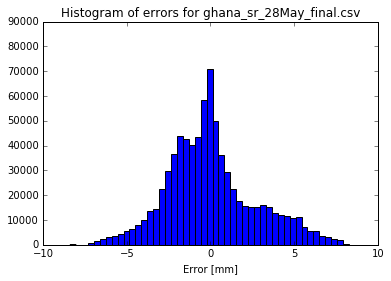

In [20]:
z_diff_poly = z_diff_poly[~np.isnan(z_diff_poly)] #remove NaN
plt.hist(z_diff_poly.flatten(),51)
plt.xlabel('Error [mm]')
plt.title('Histogram of errors for ' + filenme)
axes = plt.gca()
axes.set_ylim([0,90000])
axes.set_xlim([-10,10])

In [21]:
poly_contour_RMS = np.std(z_diff_poly,dtype=np.float64)
poly_contour_RMS

2.6732327869187307

## 3) Tilt analysis

In [22]:
#Center points around origin
data_legs = pandas.concat([ar1, ar2, ar3, ar4])
legs_doex = data_legs[2]
legs_doey = data_legs[3]
legs_doez = data_legs[4]

# Align all points around x,y center and remove the z offset
legs_doex = legs_doex - x_center
legs_doey = legs_doey - y_center
legs_z_center = (max(legs_doez) - min(legs_doez))/2
legs_doez = legs_doez - max(legs_doez) + legs_z_center

(-2.5, 2.5)

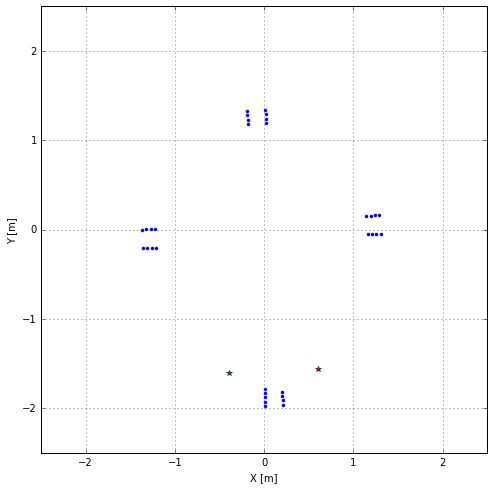

In [23]:
# Plot x,y plane
fig = plt.figure(figsize=(8,8))
pylab.plot(legs_doex,legs_doey,'.')
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
pylab.plot(ruler_x1,ruler_y1,'*',ruler_x2,ruler_y2,'*')
plt.grid()
axes = plt.gca()
axes.set_xlim([-2.5,2.5])
axes.set_ylim([-2.5,2.5])

(-0.1, 0.1)

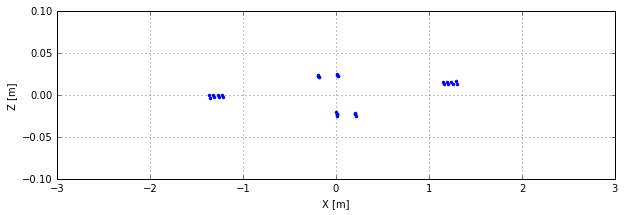

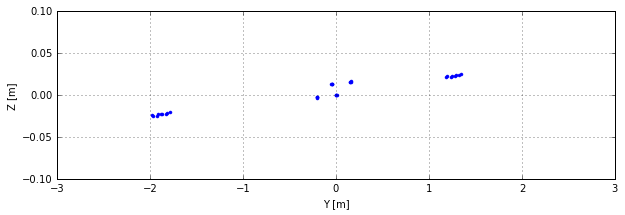

In [24]:
# Plot x,z plane
fig = plt.figure(figsize=(10,3))
pylab.plot(legs_doex,legs_doez,'.')
plt.xlabel("X [m]")
plt.ylabel("Z [m]")
plt.grid()
axes = plt.gca()
axes.set_xlim([-3,3])
axes.set_ylim([-0.1,0.1])
# Plot y,z plane
fig = plt.figure(figsize=(10,3))
pylab.plot(legs_doey,legs_doez,'.')
plt.xlabel("Y [m]")
plt.ylabel("Z [m]")
plt.grid()
axes = plt.gca()
axes.set_xlim([-3,3])
axes.set_ylim([-0.1,0.1])

### 4.1 Tilt angle calculation

In [25]:
# Angle in orthogonal direction of ruler
y_diff = np.mean(legs_doey[17:24]) - np.mean(legs_doey[0:8])
z_diff = np.mean(legs_doez[17:24]) - np.mean(legs_doez[0:8])
ang = np.arctan(z_diff/y_diff)*180/np.pi
ang

0.82908721131994567

In [26]:
# Angle in parallel direction of ruler
x_diff = np.mean(legs_doex[25:32]) - np.mean(legs_doex[9:16])
z_diff = np.mean(legs_doez[25:32]) - np.mean(legs_doez[9:16])
ang = np.arctan(z_diff/x_diff)*180/np.pi
ang

0.36281140891759184